In [ ]:

import requests 
from strategies import TickerStrategy, Strategy
from dataframe import EnhancedDataframe
import numpy as np
import pandas as pd
import math
from utilities import download_data
import timeit
import cython

@cython.cfunc
def do_once(df):
    df['Strategy Alpha'] = np.vectorize(TickerStrategy.ma_bol_rsi_signal)(
        df['Close'], df['MA50'], df["BB_lower"], df['RSI'])

    df['Strategy Beta'] = np.vectorize(TickerStrategy.r_ma20_ma50_signal)(
        df['RSI'], df['MA20'], df['MA50'])

    # df['Strategy Charlie'] = np.vectorize(TickerStrategy.ichimoku_entry)(
    #     df['senkou_span_a'], df['senkou_span_b'], df['RSI'])

    df['Strategy Delta'] = np.vectorize(
        TickerStrategy.r_sd_m_signal)(df['RSI'], df['STOCH_D'], df['MACD_histogram'])

    entries = df[(df['Strategy Alpha']) | (df['Strategy Beta']) | (df['Strategy Delta'])]

    data = Strategy.strategy_general_performance(
        entries=entries, df=df, title="Test Strategy")

    return data

@cython.cfunc
def main():
    request = requests.get(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')


    if request.ok:
        tables = pd.read_html(request.text)[0]
        tickers = [ticker if not "." in ticker else ticker.replace(
            ".", "-") for ticker in list(tables['Symbol'])]
        dfs = download_data(tickers)
        returns = []
        positive_returns = []
        for ticker in tickers:
            try:
                print(ticker)

                data = do_once(EnhancedDataframe.populate_dataframe(
                    dfs.loc[ticker].T, ticker))
                returns.append(data['returns'])
                positive_returns.append(data['positive_returns'])
            except ZeroDivisionError:
                print(ticker)
                print("Zero Division Error...")
            except ValueError:
                print(ticker)
                print("No entries")
            except Exception as e:
                print(e)
            continue

        # n = int(math.floor(np.array(returns).mean()))
        # k = int(math.floor(np.array(positive_returns).mean()))

        # print((math.comb(n, k)) * ((k / n) ** k) * ((1 - (k / n)) ** (n - k))
        #     )
    return positive_returns, returns

positive_returns, returns = main()


<AxesSubplot:xlabel='accuracy', ylabel='Density'>

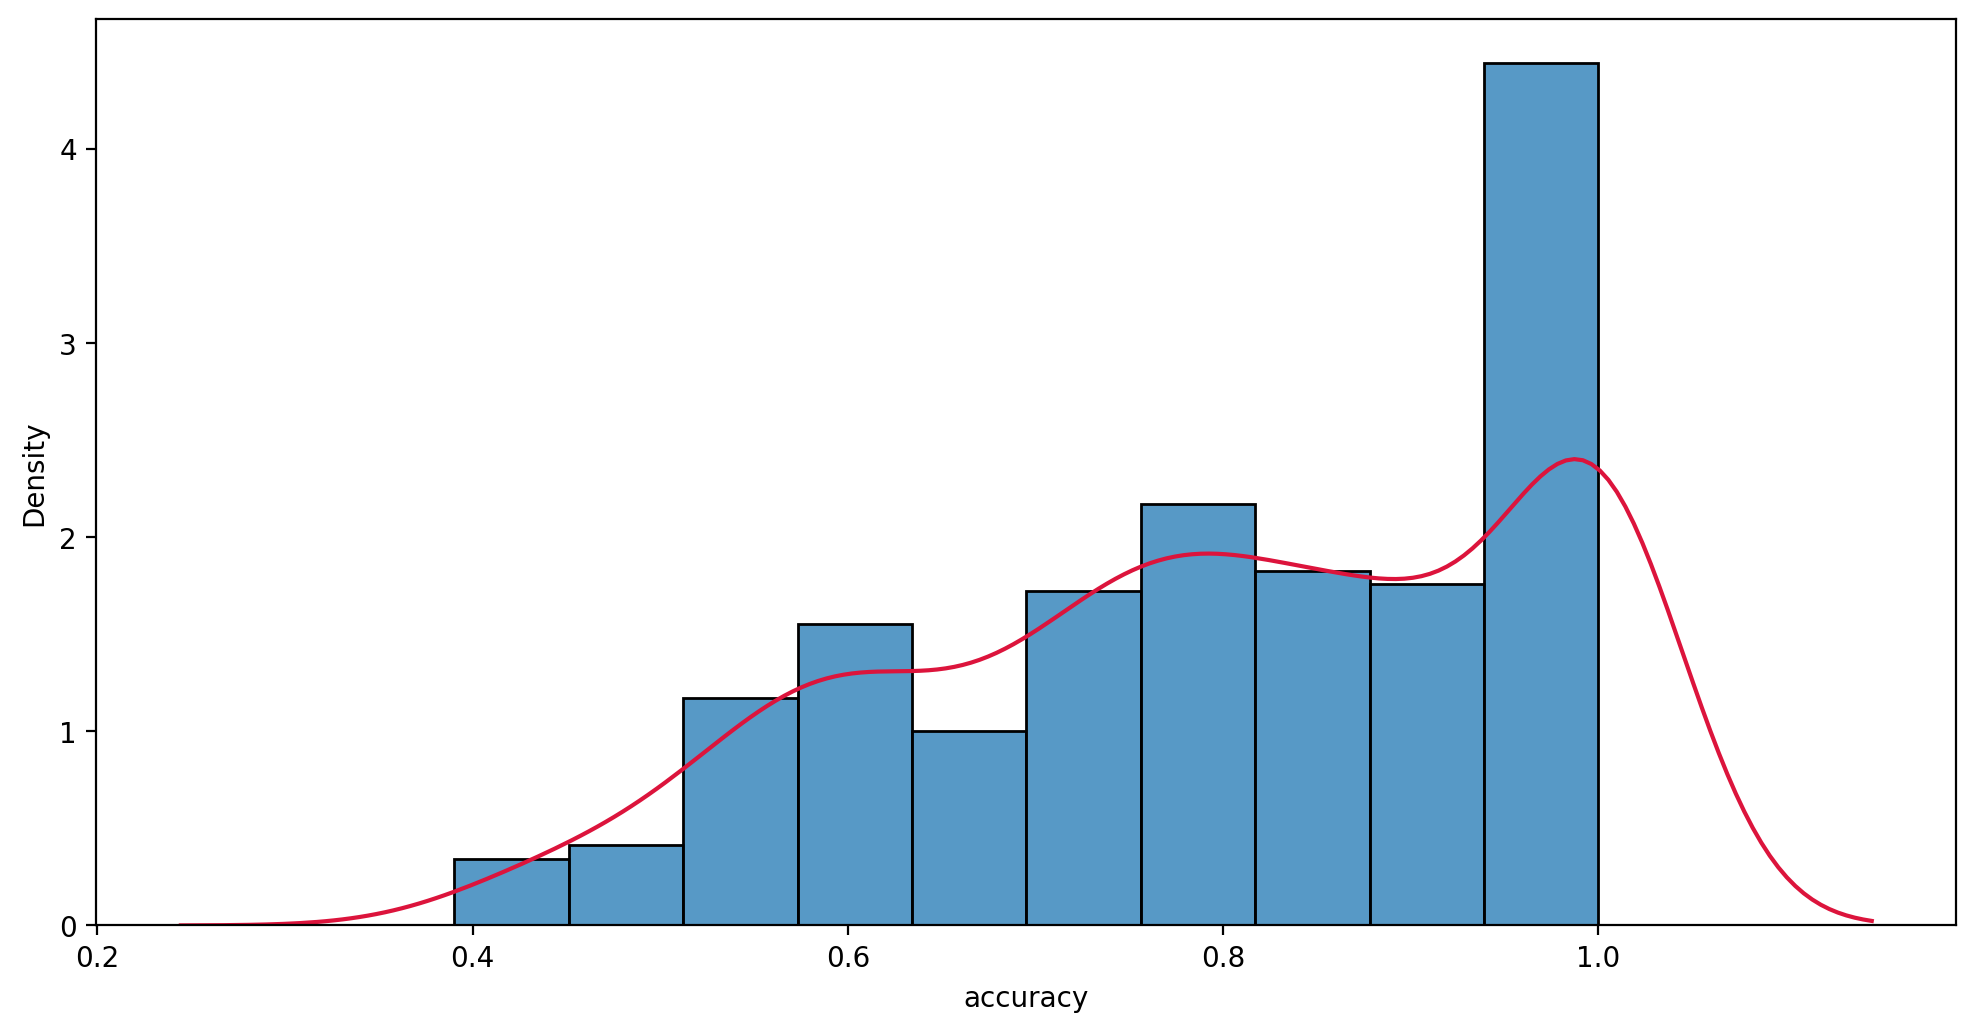

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6), dpi=200)
ax = sns.histplot(data=pd.DataFrame(data={
    "returns": returns, "positive_returns": positive_returns, "accuracy": [positive_returns[i] / returns[i] for i, _ in enumerate(positive_returns)]}),
    x="accuracy", kde=False,  stat='density')

sns.kdeplot(data=pd.DataFrame(data={
    "returns": returns, "positive_returns": positive_returns, "accuracy": [positive_returns[i] / returns[i] for i, _ in enumerate(positive_returns)]}),
    x="accuracy", color='crimson', ax=ax)


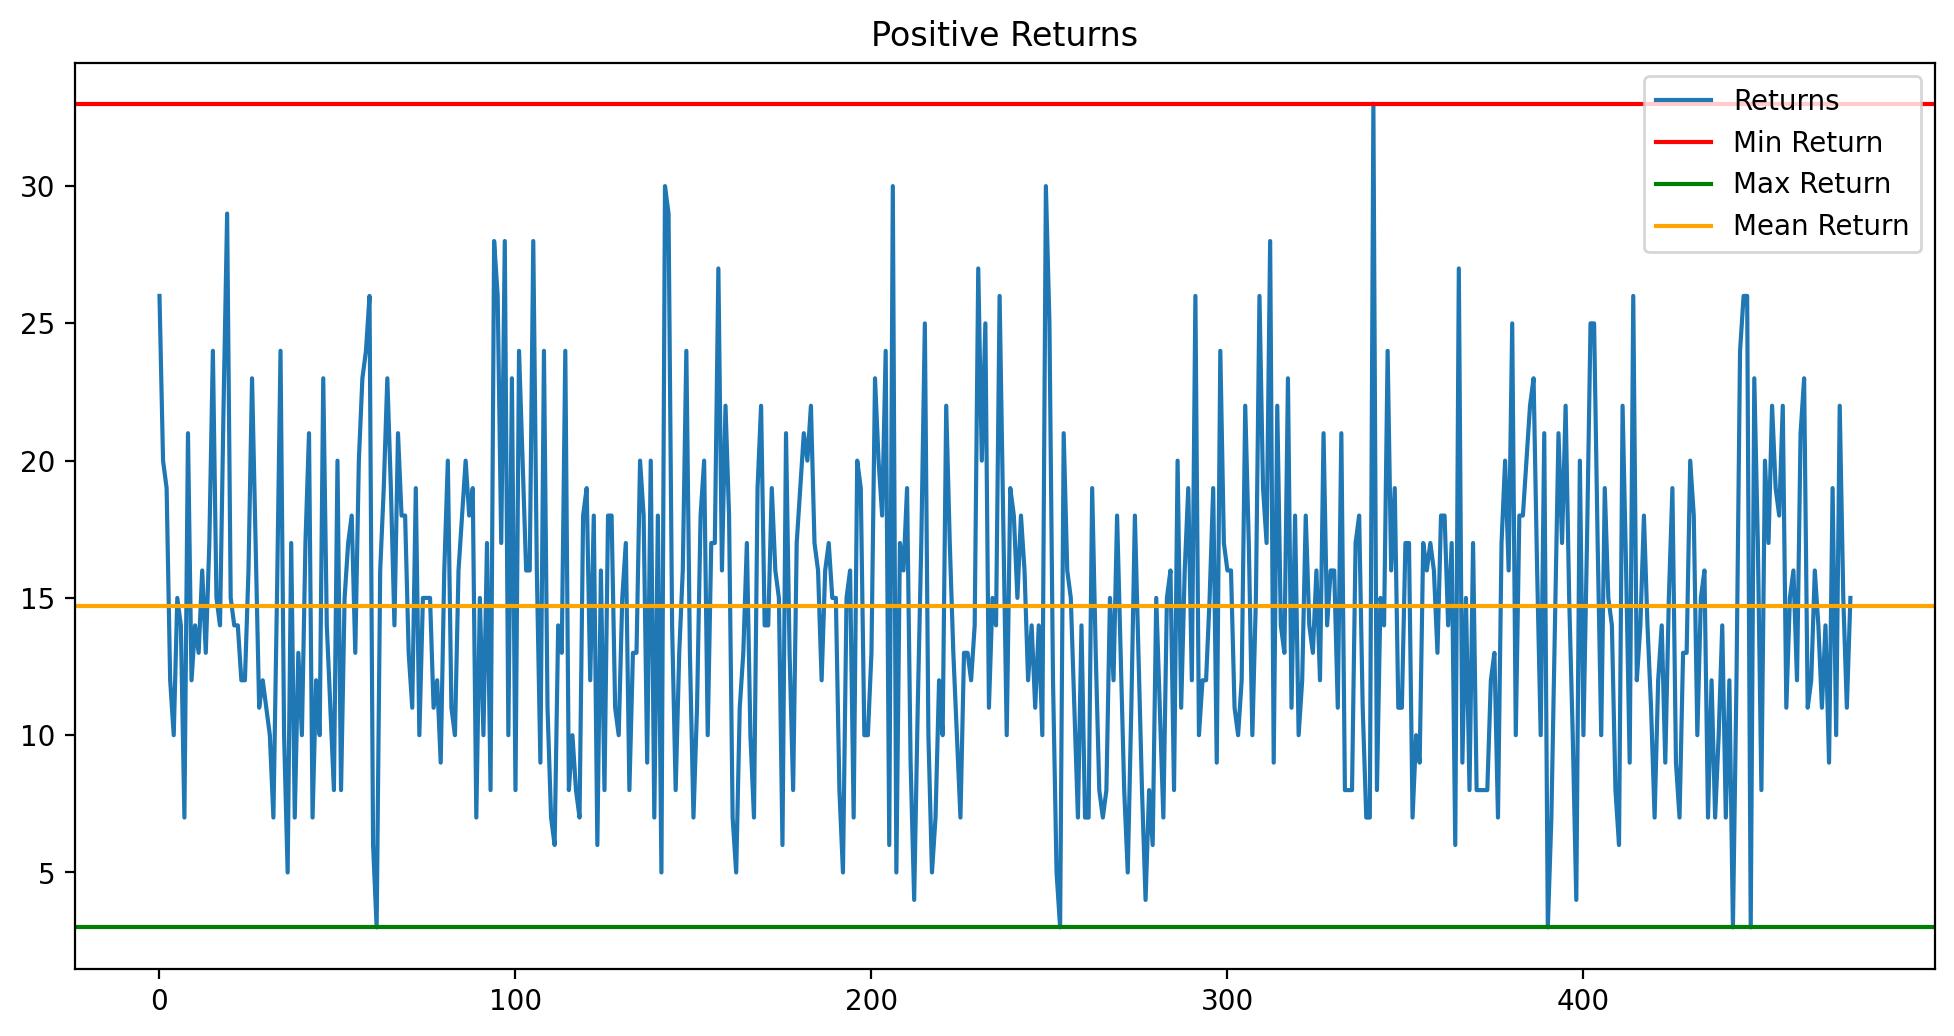

In [36]:
plt.figure(figsize=(12, 6), dpi=200)
plt.title("Positive Returns")
sns.lineplot(range(len(positive_returns)), positive_returns, label="Returns")
plt.axhline(y=max(positive_returns), label='Min Return', c='r')
plt.axhline(y=min(positive_returns), label='Max Return', c='g')
plt.axhline(y=np.array(positive_returns).mean(), label='Mean Return', c='orange')
plt.legend()
